In [1]:
import torch
import pickle
from signals_torch import steps_sequence
from torch_utils import select_gpu_with_most_free_memory
from evaporation_process import dynamics
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['axes.labelsize']=14
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11
plt.rcParams['axes.grid']=True
plt.rcParams['axes.xmargin']=0

In [4]:
# Example usage
best_gpu = select_gpu_with_most_free_memory()
device = torch.device(f'cuda:{best_gpu}' if best_gpu is not None else 'cpu')
device = "cuda:3"

with open('evaporation_process_test_set_5%2525.pickle', 'rb') as handle:
    test_set = pickle.load(handle)
with open('evaporation_process_test_set_5%_identified.pickle', 'rb') as handle:
    test_set_identified = pickle.load(handle)

T = 1000
N = len(test_set)


U = torch.zeros(2, T, device=device)
X = torch.zeros(N, 2, T+1, device=device)
Y = torch.zeros(N, 1, T, device=device)
X_hat = torch.zeros(N, 2, T+1, device=device)
Y_hat = torch.zeros(N, 1, T, device=device)

U[0,:] = steps_sequence(T, 1, 150, 250, 1, 10).T
U[1, :] = steps_sequence(T, 1, 150, 250, 1, 10).T

# constant_u = torch.tensor([191.713, 215.888], device="cuda")
# open loop experiment    
# U[0, :] = constant_u[0] + prbs(T).T
# U[1, :] = constant_u[1] + prbs(T).T

for idx in range(N):

    print('Test number:', idx)

    data = ([param.to(device) for param in test_set[idx]])
    data_identified = ([param.to(device) for param in test_set_identified[idx]])
    
    X[idx,:,0] = torch.tensor([25.0, 49.743]) #
    X_hat[idx,:,0] = torch.tensor([25.0, 49.743])
    
    for k in range(T):
        # real
        X_dot = dynamics(X[idx,:,k], U[:,k], *data)
        X[idx,:,k+1] = X[idx,:,k] + 1 * X_dot + torch.randn_like(X[idx,:,k], device=device)*.1
        Y[idx,:,k] = X[idx,0,k] + torch.randn_like(X[idx,0,k], device=device)*.1
        # identified
        X_dot_hat = dynamics(X_hat[idx,:,k], U[:,k], *data_identified)
        X_hat[idx,:,k+1] = X_hat[idx,:,k] + 1 * X_dot_hat# + torch.randn_like(X_hat[:,k], device=device)*.5
        Y_hat[idx,:,k] = X_hat[idx,0,k]# + torch.randn_like(X_hat[0,k], device=device)*.5

Selected GPU 3 with 21741 MB free memory.
Test number: 0
Test number: 1
Test number: 2
Test number: 3
Test number: 4
Test number: 5
Test number: 6
Test number: 7
Test number: 8
Test number: 9
Test number: 10
Test number: 11
Test number: 12
Test number: 13
Test number: 14
Test number: 15
Test number: 16
Test number: 17
Test number: 18
Test number: 19


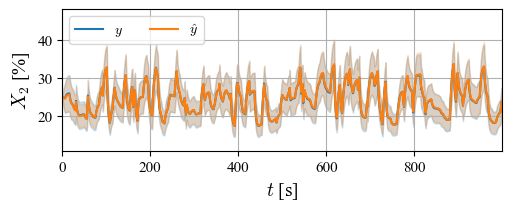

In [5]:
# Create a 2x1 subplot layout for the main figure
fig = plt.figure(figsize=(5, 2), constrained_layout=True)

mean_Y = Y[:,0,:].mean(axis=0).cpu().detach().numpy()
std_Y = Y[:,0,:].std(axis=0).cpu().detach().numpy()

mean_Y_hat = Y_hat[:,0,:].mean(axis=0).cpu().detach().numpy()
std_Y_hat = Y_hat[:,0,:].std(axis=0).cpu().detach().numpy()

plt.plot(mean_Y, color='tab:blue', label='$y$')
plt.plot(mean_Y_hat, color='tab:orange', label='$\hat{y}$')

plt.fill_between(range(len(mean_Y)), mean_Y - std_Y, mean_Y + std_Y, color='tab:blue', alpha=0.2)
plt.fill_between(range(len(mean_Y_hat)), mean_Y_hat - std_Y_hat, mean_Y_hat + std_Y_hat, color='tab:orange', alpha=0.2)

plt.legend(ncols=2, loc="upper left")

plt.xlabel('$t$ [s]')
plt.ylabel('$X_2$ [%]')

plt.ylim([11, 48])


# plt.savefig('test_greybox_identification.pdf')

plt.show()

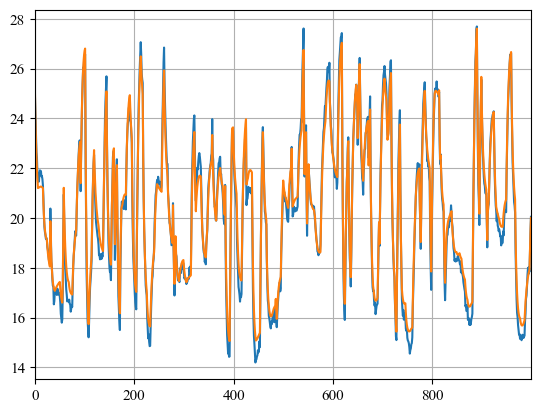

In [6]:
plt.plot(Y[1,0,:].cpu(), color='tab:blue', label='$y$')
plt.plot(Y_hat[1,0,:].cpu(), color='tab:orange', label='$\hat{y}$')

In [7]:
import numpy as np
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(Y[:,0,:].cpu().detach().numpy(), Y_hat[:,0,:].cpu().detach().numpy()))

0.7013771

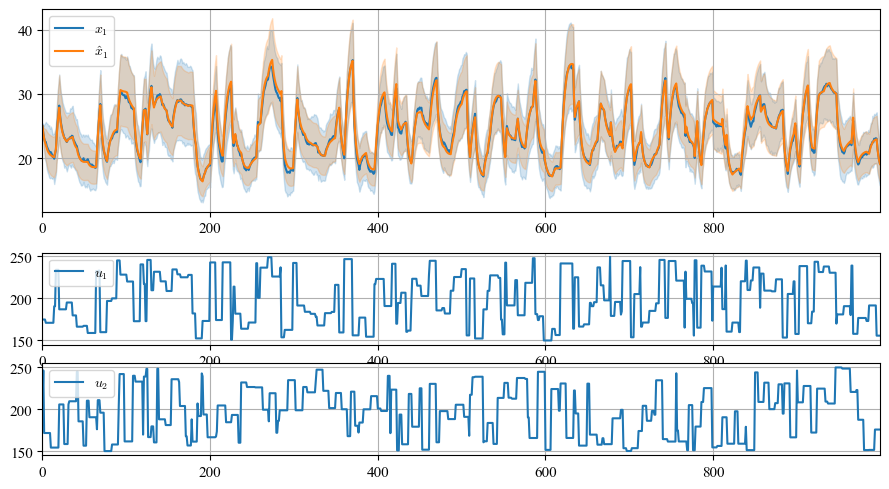

In [5]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Create a 2x1 subplot layout for the main figure
fig = plt.figure(figsize=(9, 5))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1])  # 2 rows, 1 column, larger top plot

# First subplot (mean ± std for Y and Y_hat)
ax1 = fig.add_subplot(gs[0])

mean_Y = Y[:,0,:].mean(axis=0).cpu().detach().numpy()
std_Y = Y[:,0,:].std(axis=0).cpu().detach().numpy()

mean_Y_hat = Y_hat[:,0,:].mean(axis=0).cpu().detach().numpy()
std_Y_hat = Y_hat[:,0,:].std(axis=0).cpu().detach().numpy()

ax1.plot(mean_Y, color='tab:blue', label='$x_1$')
ax1.plot(mean_Y_hat, color='tab:orange', label='$\hat{x}_1$')

ax1.fill_between(range(len(mean_Y)), mean_Y - std_Y, mean_Y + std_Y, color='tab:blue', alpha=0.2)
ax1.fill_between(range(len(mean_Y_hat)), mean_Y_hat - std_Y_hat, mean_Y_hat + std_Y_hat, color='tab:orange', alpha=0.2)

ax1.legend()

# Second subplot (split further into 2 subplots for u1 and u2)
gs2 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[1])  # Further split the second row

# Subplot for u_1
ax2_1 = fig.add_subplot(gs2[0])
ax2_1.plot(U[0, :].cpu().detach().numpy(), label='$u_1$', color='tab:blue')
ax2_1.legend()

# Subplot for u_2
ax2_2 = fig.add_subplot(gs2[1])
ax2_2.plot(U[1, :].cpu().detach().numpy(), label='$u_2$', color='tab:blue')
ax2_2.legend()

# Adjust layout to ensure spacing is correct
plt.tight_layout()

# Show the plot
plt.show()
